In [1]:
import torch
import torch.nn as nn

## LSTM

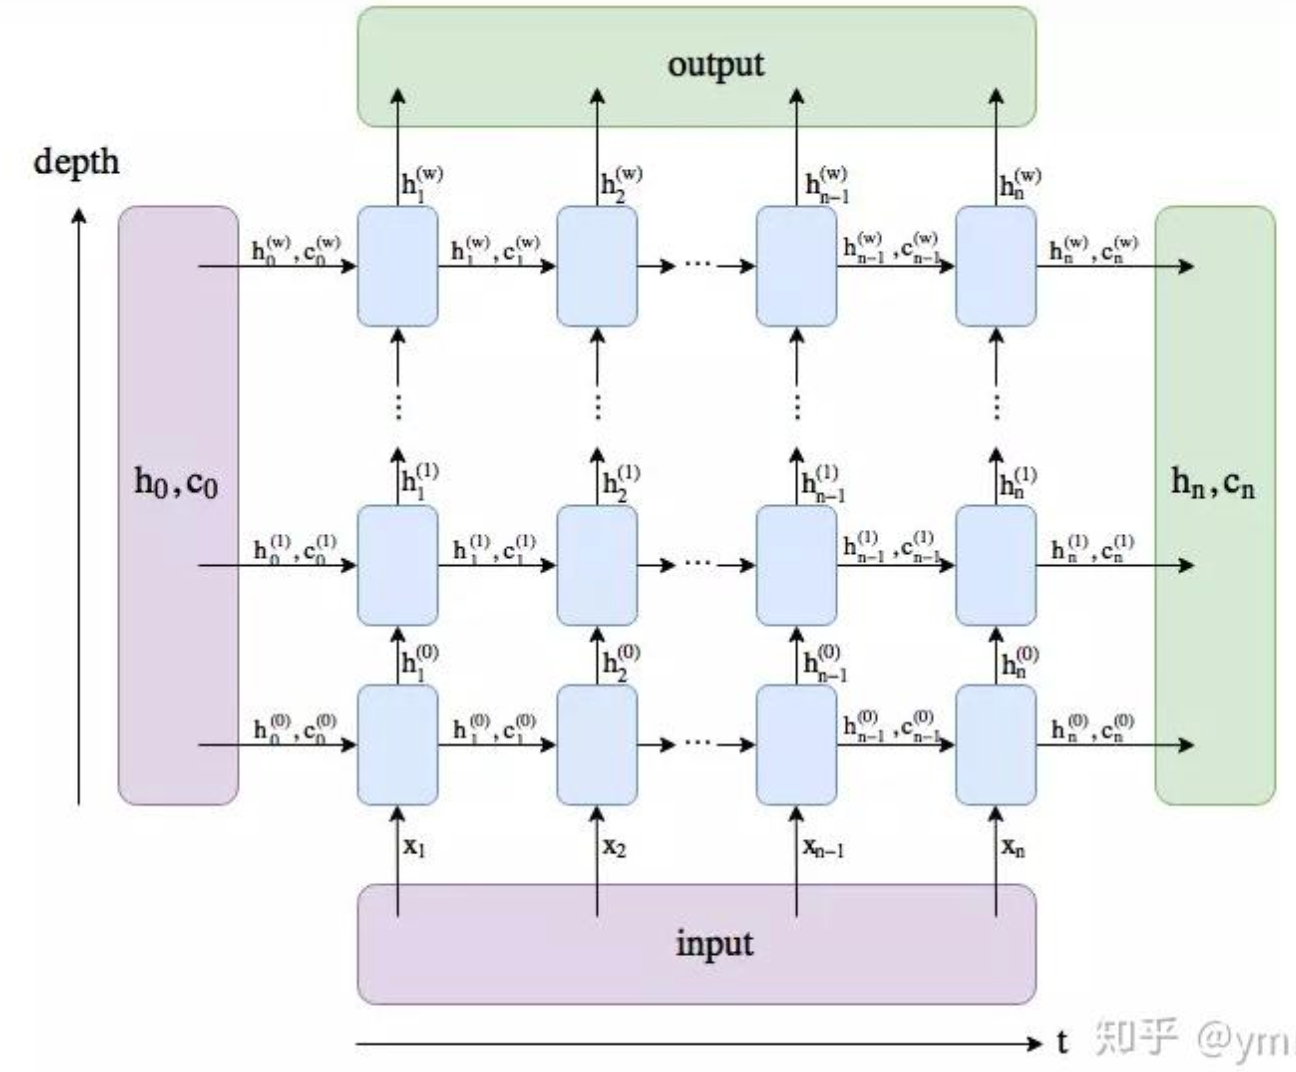

图片来源：[LSTM细节分析理解（pytorch版）](https://zhuanlan.zhihu.com/p/79064602)

In [23]:
rnn = nn.LSTM(input_size=5, hidden_size=6, num_layers=1, bias=False, batch_first=True, bidirectional=False)
"""
LSTM中有四个全连接(三个门结构 + 一个状态信息提取的结构)
weight_ih_l0 torch.Size([24, 5])  --> 针对当前输入的全连接处理
weight_hh_l0 torch.Size([24, 6])  --> 针对上一个时刻的输出的全连接处理
NOTE: 24 = 6 * 4  -> 6就是hidden_size, 4就是lstm中的四个全连接
"""

for name, param in rnn.named_parameters():
    print(name, param.shape)


weight_ih_l0 torch.Size([24, 5])
weight_hh_l0 torch.Size([24, 6])


In [21]:
# 模型输出
x = torch.randn(3, 4, 5)
output, (hn, cn) = rnn(x)
print(output.shape)  # output是最后一层每个时刻的输出特征信息 [n,t,hidden_size]
print(hn.shape)  # 最后一个时刻的输出ht [(2 if bidirectional else 1) * num_layers, N, hidden_size]
print(cn.shape)  # 最后一个时刻的状态ct [(2 if bidirectional else 1) * num_layers, N, hidden_size]

print(output[:, -1, :] - hn[-1, :, :])

torch.Size([3, 4, 6])
torch.Size([1, 3, 6])
torch.Size([1, 3, 6])
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)


In [12]:
# 手动实现
n, t, _ = x.shape
outputs = []
hns = torch.zeros((1, n, 6))  # 初始状态
cns = torch.zeros((1, n, 6))  # 初始状态
for i in range(t):
    # 1. 当前输入信息的提取
    cx = torch.matmul(x[:, i, :], rnn.weight_ih_l0.T)  # [3,24]
    cx_f, cx_i, cx_c, cx_o = torch.split(cx, 6, dim=1)
    # 2. 上一个的状态信息的转换
    ch = torch.matmul(hns[0], rnn.weight_hh_l0.T)  # [3,6]*[6,24] --> [3,24]
    ch_f, ch_i, ch_c, ch_o = torch.split(ch, 6, dim=1)
    # 3. 合并
    cf = torch.sigmoid(cx_f + ch_f)
    ci = torch.sigmoid(cx_i + ch_i)
    cc = torch.tanh(cx_c + ch_c)
    co = torch.sigmoid(cx_o + ch_o)
    # 合并状态信息和输出信息
    ct = cns[0] * cf + cc * ci
    ht = torch.tanh(ct) * co
    outputs.append(torch.unsqueeze(ht, dim=1))
    hns[0] = ht
    cns[0] = ct
outputs = torch.concat(outputs, dim=1)  # [3,T,hidden_size]
print(outputs.shape)

torch.Size([3, 4, 6])


In [16]:
print(cns - cn)

tensor([[[-0.0249, -0.0499, -0.0760, -0.0361,  0.0072, -0.0482],
         [ 0.2038, -0.0202, -0.2442,  0.1584,  0.1576, -0.2009],
         [ 0.0694,  0.0429, -0.0950,  0.0008,  0.1359, -0.0629]]],
       grad_fn=<SubBackward0>)


In [14]:
output

tensor([[[ 0.0925,  0.1881, -0.0517,  0.0408, -0.0160, -0.0220],
         [ 0.1273,  0.1003,  0.0023, -0.0281, -0.0677,  0.1128],
         [ 0.0690, -0.0005, -0.0255, -0.0128,  0.0711,  0.1355],
         [ 0.1457,  0.1583, -0.1125,  0.0107,  0.1347,  0.0954]],

        [[ 0.1026,  0.0296,  0.0188,  0.0193, -0.0610,  0.0444],
         [ 0.1266,  0.2064, -0.0546, -0.1131, -0.0952,  0.1010],
         [-0.0694, -0.2162,  0.0355,  0.0811, -0.1386, -0.0069],
         [ 0.0257, -0.0011, -0.0420, -0.0408,  0.1290,  0.0846]],

        [[-0.0899, -0.0491, -0.0310,  0.1059,  0.1581, -0.1142],
         [-0.2813,  0.0017,  0.1197,  0.1053, -0.0265, -0.1809],
         [-0.0034, -0.0957, -0.0038,  0.1027,  0.1848,  0.0018],
         [-0.1459, -0.0220,  0.0437,  0.0429,  0.0620, -0.0383]]],
       grad_fn=<TransposeBackward0>)

In [15]:
outputs

tensor([[[ 0.0445,  0.1660, -0.0352,  0.0460, -0.0219, -0.0229],
         [ 0.0953,  0.0939,  0.0073, -0.0718, -0.1037,  0.0867],
         [ 0.0588, -0.0039, -0.0662, -0.0401,  0.0571,  0.1140],
         [ 0.1357,  0.1236, -0.1473, -0.0014,  0.1394,  0.0747]],

        [[ 0.0362,  0.0270,  0.0104,  0.0365, -0.0801,  0.0441],
         [ 0.1317,  0.1659, -0.0789, -0.0720, -0.1225,  0.0942],
         [ 0.0383, -0.2625, -0.0156,  0.1365, -0.1341, -0.1908],
         [ 0.0771, -0.0100, -0.1463,  0.0449,  0.2178, -0.0150]],

        [[-0.1032, -0.0550, -0.0339,  0.0814,  0.1228, -0.1170],
         [-0.2488,  0.0110,  0.0517,  0.0904,  0.0253, -0.2026],
         [ 0.0254, -0.0737, -0.0633,  0.0813,  0.2630, -0.0581],
         [-0.1055, -0.0058, -0.0100,  0.0435,  0.1212, -0.0701]]],
       grad_fn=<CatBackward0>)

In [24]:
torch.mean(output-outputs)

tensor(0.0310, grad_fn=<MeanBackward0>)

## StockLSTM

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设data是一个形状为(100, 5)的张量，包含100天的股票特征
data = torch.randn(100, 5)   # 开盘价、最高价、最低价、收盘价和交易量

# 定义时间窗口大小
window_size = 4

# 构建x和y
x = []
y = []

for i in range(len(data) - window_size):
    # 确保每个样本都是形状为(1, window_size, 5)的张量
    sample_x = data[i:i + window_size].unsqueeze(0)  # 增加一个批次维度
    x.append(sample_x)
    y.append(data[i + window_size, 3])  # 假设我们预测的是第4个特征，即收盘价

# 将x和y转换为PyTorch张量
x = torch.cat(x, dim=0)  # 沿着第一个维度（批次维度）堆叠张量
y = torch.tensor(y, dtype=torch.float32)  # y的形状将是(96,)

# 定义LSTM模型
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)  # 预测一个值，即收盘价

    def forward(self, x):
        # LSTM层输出：(batch_size, seq_length, hidden_size)
        # hn和cn分别是最后一个时间步的隐藏状态和细胞状态
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]  # 取最后一个时间步的输出
        out = self.linear(out)  # 通过线性层预测收盘价
        return out

# 实例化模型
model = StockLSTM(input_size=5, hidden_size=6, num_layers=1)

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失，适用于回归问题
optimizer = optim.SGD(model.parameters(), lr=0.01)  # SGD优化器

# 训练模型
epochs = 20
batch_size = 3
num_batches = len(x) // batch_size

for epoch in range(epochs):
    for batch in range(num_batches):
        # 获取一个批次的数据
        start = batch * batch_size
        end = start + batch_size
        batch_x = x[start:end]  # 形状为(batch_size, 4, 5)
        batch_y = y[start:end].unsqueeze(-1)  # 形状为(batch_size, 1)

        # 前向传播
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # 反向传播和优化
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

    print(f'Epoch [{epoch+1}/{epochs}], Batch Loss: {loss.item():.4f}')

print("Training complete")

Epoch [1/20], Batch Loss: 2.9748
Epoch [2/20], Batch Loss: 3.0214
Epoch [3/20], Batch Loss: 3.0458
Epoch [4/20], Batch Loss: 3.0583
Epoch [5/20], Batch Loss: 3.0650
Epoch [6/20], Batch Loss: 3.0688
Epoch [7/20], Batch Loss: 3.0713
Epoch [8/20], Batch Loss: 3.0732
Epoch [9/20], Batch Loss: 3.0748
Epoch [10/20], Batch Loss: 3.0763
Epoch [11/20], Batch Loss: 3.0777
Epoch [12/20], Batch Loss: 3.0790
Epoch [13/20], Batch Loss: 3.0803
Epoch [14/20], Batch Loss: 3.0815
Epoch [15/20], Batch Loss: 3.0826
Epoch [16/20], Batch Loss: 3.0836
Epoch [17/20], Batch Loss: 3.0845
Epoch [18/20], Batch Loss: 3.0851
Epoch [19/20], Batch Loss: 3.0855
Epoch [20/20], Batch Loss: 3.0856
Training complete


## StockLSTM_2

### 导入包

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt

### 构造数据

In [ ]:
# 假设data是一个形状为(100, 5)的张量，包含100天的股票特征
data = torch.randn(100, 5)   # 开盘价、最高价、最低价、收盘价和交易量

# 定义时间窗口大小
window_size = 4

### 定义Dataset & DataLoader

In [ ]:
# 自定义数据集
class StockDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.x, self.y = self.prepare_data()

    def prepare_data(self):
        x = []
        y = []
        for i in range(len(self.data) - self.window_size):
            sample_x = self.data[i:i + self.window_size]  # 形状为(window_size, 5)
            x.append(sample_x)
            y.append(self.data[i + self.window_size, 3])  # 预测收盘价
        return torch.stack(x), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# 创建数据集实例
dataset = StockDataset(data, window_size)

# 使用DataLoader加载数据集
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### 定义模型

In [ ]:
# 定义LSTM模型
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)  # 预测一个值，即收盘价

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]  # 取最后一个时间步的输出
        out = self.linear(out)  # 通过线性层预测收盘价
        return out

# 实例化模型
model = StockLSTM(input_size=5, hidden_size=6, num_layers=1)

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失，适用于回归问题
optimizer = optim.SGD(model.parameters(), lr=0.01)  # SGD优化器

### 训练模型

In [38]:
# 训练模型
epochs = 3000
losses = []  # 用于存储每个批次的损失值

for epoch in range(1, epochs + 1):
    bar = tqdm(dataloader, desc=f'Epoch {epoch}/{epochs}')
    for batch_x, batch_y in bar:
        batch_x = batch_x.unsqueeze(1)  # 增加一个批次维度，形状变为(batch_size, 1, window_size, 5)
        batch_x = batch_x.squeeze(1)    # 去掉多余的维度，形状变为(batch_size, window_size, 5)
        batch_y = batch_y.unsqueeze(-1)  # 形状变为(batch_size, 1)

        # 前向传播
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # 反向传播和优化
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        # 更新进度条信息
        bar.set_postfix(train_loss=loss.item())
        losses.append(loss.item())  # 存储损失值

print("Training complete")


Epoch 3000/3000: 100%|██████████| 12/12 [00:00<00:00, 1349.52it/s, train_loss=0.000296]

Training complete


### loss展示

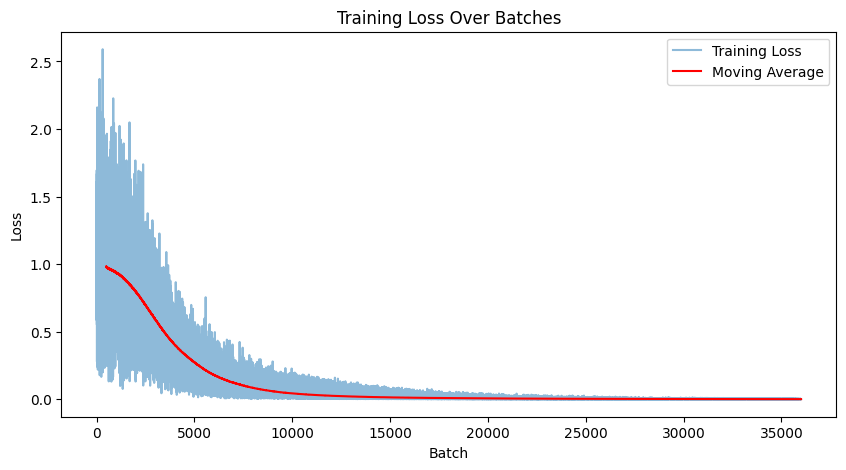

In [39]:
import matplotlib.pyplot as plt

# 假设losses是之前收集的每个批次的损失值列表
# 计算滑动平均
window_size = 500
moving_averages = []
for i in range(len(losses) - window_size + 1):
    window = losses[i : i + window_size]
    window_average = sum(window) / window_size
    moving_averages.append(window_average)

# 绘制原始损失和滑动平均损失
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss', alpha=0.5)  # 原始损失，半透明
plt.plot(range(window_size - 1, len(losses)), moving_averages, label='Moving Average', color='red')  # 滑动平均，红色线
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Batches')
plt.legend()
plt.show()

## GRU

In [44]:
"""
GRU中三个全连接(两个门结构 + 一个当前状态信息提取的结构)
weight_ih_l0 torch.Size([18, 5])
weight_hh_l0 torch.Size([18, 6])
bias_ih_l0 torch.Size([18])
bias_hh_l0 torch.Size([18])
18 = 6 * 3 6表示hidden_size向量大小，3表示gru中的全连接数目
"""
rnn = nn.GRU(input_size=5, hidden_size=6, num_layers=1, bias=True, batch_first=True, bidirectional=False)


In [45]:
for name, param in rnn.named_parameters():
    print(name, param.shape)


weight_ih_l0 torch.Size([18, 5])
weight_hh_l0 torch.Size([18, 6])
bias_ih_l0 torch.Size([18])
bias_hh_l0 torch.Size([18])


In [46]:
x = torch.randn(3, 4, 5)  # [n,t,input_size]
output, hn = rnn(x)
print(output.shape)  # output是最后一层每个时刻的输出特征信息 [n,t,hidden_size]
print(hn.shape)  # 最后一个时刻的输出ht/状态信息hn [(2 if bidirectional else 1) * num_layers, N, hidden_size]


torch.Size([3, 4, 6])
torch.Size([1, 3, 6])
